# Looking at a newer data set.
*<u>Authors:</u>* Lukas Gust, Omar Hussain.<br>
*<u>Date:</u>* 4/21/2018<br>
*<u>Project:</u>* Crazy-Taxi-IRL, Final Project for MATH 4100 Intro. to Data Science<br>

In another notebook we looked at some taxi data from 2016 because it had GPS coordinates for pickup and dropoff information. In order to predict ending location based off starting location we would have to 'bucket' the data into bins and predict the bins, otherwise there would be an infinite amount of possible outcomes and beginnings. The 2017 data already has the locational data seperated into bins, loosely based off of neighborhoods in New York.

![Taxi Zones](./zonemap.png)

## First look at the zones.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta
import calendar

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
sns.set()
%matplotlib inline  
plt.rcParams['figure.figsize'] = (15, 10)

In [27]:
zone_df = pd.read_csv('taxi_zones.csv')
zone_df.rename(inplace=True, columns={'zone,C,254':'Zone', 'LocationID,N,4,0':'Location ID', 'borough,C,254':'Borough', 'Shape_Area,N,19,11':'Area'})
zone_df.sort_values('Location ID').head()

,"OBJECTID,N,9,0","Shape_Leng,N,19,11",Area,Zone,Location ID,Borough
0,1,0.116357,0.000782,Newark Airport,1,EWR
1,2,0.433470,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,0.000498,Arden Heights,5,Staten Island


In [28]:
zone_df[zone_df.duplicated(subset='Location ID')]

,"OBJECTID,N,9,0","Shape_Leng,N,19,11",Area,Zone,Location ID,Borough
56,57,0.019271,0.000018,Corona,56,Queens
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan


In [29]:
zone_df.drop_duplicates(subset='Location ID', inplace=True)
zone_df.reset_index(inplace=True)

In [30]:
zone_df.drop(labels=['index', 'OBJECTID,N,9,0', 'Shape_Leng,N,19,11'], inplace=True, axis=1)

In [31]:
zone_df.head()

,Area,Zone,Location ID,Borough
0,0.000782,Newark Airport,1,EWR
1,0.004866,Jamaica Bay,2,Queens
2,0.000314,Allerton/Pelham Gardens,3,Bronx
3,0.000112,Alphabet City,4,Manhattan
4,0.000498,Arden Heights,5,Staten Island


In [33]:
zone_df.shape

(260, 4)

The zone data is now cleaned. We had to remove a few duplicate entries and some unneeded columns as well as rename them to more friendly names.

# Taxi Data!

This set of data is from December 2017 and contains pickup and drop off ID's instead of GPS coordinates.

In [32]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

yellow_data = pd.read_csv('TaxiData/yellow_tripdata_2017-12.csv', \
                          parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'], date_parser=dateparse)
green_data = pd.read_csv('TaxiData/green_tripdata_2017-12.csv', \
                         parse_dates = ['lpep_pickup_datetime', 'lpep_dropoff_datetime'],date_parser=dateparse)


yellow_data.dropna(subset=['DOLocationID', 'PULocationID'], inplace=True)
green_data.dropna(subset=['DOLocationID', 'PULocationID'], inplace=True)

In [33]:
yellow_data['trip_duration'] = yellow_data['tpep_dropoff_datetime'] - yellow_data['tpep_pickup_datetime']

green_data['trip_duration'] = green_data['lpep_dropoff_datetime'] - green_data['lpep_pickup_datetime']

yellow_data['trip_duration'] = yellow_data['trip_duration'].dt.seconds/60

green_data['trip_duration'] = green_data['trip_duration'].dt.seconds/60

yellow_data['trip_dayofmonth'] = yellow_data['tpep_dropoff_datetime'].dt.day
green_data['trip_dayofmonth'] = green_data['lpep_dropoff_datetime'].dt.day

yellow_data['trip_dayofweek'] = yellow_data['tpep_dropoff_datetime'].dt.dayofweek
green_data['trip_dayofweek'] = green_data['lpep_dropoff_datetime'].dt.dayofweek

yellow_data['trip_DO_hourofday'] = yellow_data['tpep_dropoff_datetime'].dt.hour
green_data['trip_DO_hourofday'] = green_data['lpep_dropoff_datetime'].dt.hour

yellow_data['trip_PU_hourofday'] = yellow_data['tpep_pickup_datetime'].dt.hour
green_data['trip_PU_hourofday'] = green_data['lpep_pickup_datetime'].dt.hour

In [34]:
yellow_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_dayofmonth,trip_dayofweek,trip_DO_hourofday,trip_PU_hourofday
0,1,2017-12-01 00:12:00,2017-12-01 00:12:51,1,0.0,1,N,226,226,3,...,0.5,0.0,0.0,0.3,3.8,0.850000,1,4,0,0
1,1,2017-12-01 00:13:37,2017-12-01 00:13:47,1,0.0,1,N,226,226,3,...,0.5,0.0,0.0,0.3,3.8,0.166667,1,4,0,0
2,1,2017-12-01 00:14:15,2017-12-01 00:15:05,1,0.0,1,N,226,226,3,...,0.5,0.0,0.0,0.3,3.8,0.833333,1,4,0,0
3,1,2017-12-01 00:15:33,2017-12-01 00:15:37,1,0.0,1,N,226,226,3,...,0.5,0.0,0.0,0.3,3.8,0.066667,1,4,0,0
4,1,2017-12-01 00:50:03,2017-12-01 00:53:35,1,0.0,1,N,145,145,2,...,0.5,0.0,0.0,0.3,5.3,3.533333,1,4,0,0


In [35]:
green_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,trip_duration,trip_dayofmonth,trip_dayofweek,trip_DO_hourofday,trip_PU_hourofday
0,1,2017-12-01 00:33:14,2017-12-01 00:40:22,N,1,42,24,1,1.40,7.5,...,NaN,0.3,8.80,2,1.0,7.133333,1,4,0,0
1,2,2017-12-01 00:16:06,2017-12-01 00:23:11,N,1,49,25,5,1.60,7.5,...,NaN,0.3,11.44,1,1.0,7.083333,1,4,0,0
2,2,2017-12-01 00:24:05,2017-12-01 00:32:24,N,1,25,49,5,1.91,8.5,...,NaN,0.3,11.80,1,1.0,8.316667,1,4,0,0
3,2,2017-12-01 00:47:42,2017-12-01 01:02:11,N,1,256,198,5,3.54,13.5,...,NaN,0.3,14.80,2,1.0,14.483333,1,4,1,0
4,2,2017-12-01 00:21:33,2017-12-01 00:41:14,N,1,244,140,2,7.79,24.0,...,NaN,0.3,30.36,1,1.0,19.683333,1,4,0,0


In [36]:
yellow_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_dayofmonth,trip_dayofweek,trip_DO_hourofday,trip_PU_hourofday
count,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06,9.508276e+06
mean,1.552153e+00,1.632386e+00,2.841248e+00,1.040817e+00,1.639006e+02,1.618380e+02,1.345665e+00,1.293521e+01,3.221178e-01,4.972710e-01,1.813980e+00,3.149101e-01,2.996154e-01,1.618621e+01,1.741730e+01,1.499809e+01,3.218610e+00,1.373943e+01,1.373333e+01
std,4.972727e-01,1.264036e+00,3.665802e+00,4.193037e-01,6.687440e+01,7.062320e+01,4.963531e-01,1.276011e+02,4.489527e-01,5.557419e-02,2.599233e+00,1.847027e+00,1.455794e-02,1.278660e+02,6.433474e+01,8.672834e+00,1.936288e+00,6.329262e+00,6.231663e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-3.400000e+02,-1.000000e+01,-5.000000e-01,-2.180000e+02,-1.900000e+01,-3.000000e-01,-3.403000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,9.300000e-01,1.000000e+00,1.140000e+02,1.120000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00,6.600000e+00,8.000000e+00,2.000000e+00,1.000000e+01,1.000000e+01
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.320000e+00,0.000000e+00,3.000000e-01,1.180000e+01,1.130000e+01,1.500000e+01,3.000000e+00,1.400000e+01,1.400000e+01
75%,2.000000e+00,2.000000e+00,2.950000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.450000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.780000e+01,1.880000e+01,2.200000e+01,5.000000e+00,1.900000e+01,1.900000e+01
max,2.000000e+00,9.000000e+00,6.872200e+02,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,3.919118e+05,6.980000e+01,1.178500e+02,4.960000e+02,9.758900e+02,1.000000e+00,3.919136e+05,1.439983e+03,3.100000e+01,6.000000e+00,2.300000e+01,2.300000e+01


In [37]:
green_data.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,trip_duration,trip_dayofmonth,trip_dayofweek,trip_DO_hourofday,trip_PU_hourofday
count,906240.000000,906240.000000,906240.000000,906240.000000,906240.000000,906240.000000,906240.000000,906240.000000,906240.000000,906240.000000,...,0.0,906240.000000,906240.000000,906240.000000,906239.000000,906240.000000,906240.000000,906240.000000,906240.000000,906240.000000
mean,1.825838,1.071538,110.812352,128.507389,1.368185,2.677710,11.874872,0.340943,0.488398,1.049092,...,NaN,0.293318,14.172645,1.494520,1.017056,21.072679,15.407871,3.328473,13.979841,13.964410
std,0.379249,0.529394,74.923133,76.960416,1.050139,2.868094,9.898816,0.389945,0.082981,1.927127,...,NaN,0.049000,10.983033,0.522221,0.129481,103.678375,8.858151,1.938720,6.348936,6.261508
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-140.000000,-4.500000,-0.500000,-88.800000,...,NaN,-0.300000,-140.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,49.000000,61.000000,1.000000,1.000000,6.000000,0.000000,0.500000,0.000000,...,NaN,0.300000,7.800000,1.000000,1.000000,5.966667,8.000000,2.000000,10.000000,10.000000
50%,2.000000,1.000000,82.000000,129.000000,1.000000,1.710000,9.000000,0.500000,0.500000,0.000000,...,NaN,0.300000,10.800000,1.000000,1.000000,10.066667,15.000000,4.000000,15.000000,15.000000
75%,2.000000,1.000000,166.000000,191.000000,1.000000,3.280000,14.500000,0.500000,0.500000,1.760000,...,NaN,0.300000,16.800000,2.000000,1.000000,16.783333,22.000000,5.000000,19.000000,19.000000
max,2.000000,99.000000,265.000000,265.000000,9.000000,108.730000,2134.000000,4.500000,0.500000,200.080000,...,NaN,0.300000,2134.800000,5.000000,2.000000,1439.866667,31.000000,6.000000,23.000000,23.000000


It seems like some folks paid over \$2000 for a green taxi ride and \$300000 for a yellow taxi ride! 

In [38]:
yellow_data = yellow_data[(yellow_data['fare_amount'] >= 0) & (yellow_data['fare_amount'] <= 100) & \
                          (yellow_data['trip_distance'] >= 0) & (yellow_data['trip_distance'] <= 40)]
green_data = green_data[(green_data['fare_amount'] >= 0) & (green_data['fare_amount'] <= 100) & \
                        (green_data['trip_distance'] >= 0) & (green_data['trip_distance'] <= 40)]


In [39]:
yellow_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_dayofmonth,trip_dayofweek,trip_DO_hourofday,trip_PU_hourofday
count,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06,9.496844e+06
mean,1.551867e+00,1.632331e+00,2.828635e+00,1.038266e+00,1.638989e+02,1.618016e+02,1.344701e+00,1.281211e+01,3.226299e-01,4.979657e-01,1.806736e+00,3.106390e-01,2.999301e-01,1.605312e+01,1.739875e+01,1.499826e+01,3.218556e+00,1.374051e+01,1.373421e+01
std,4.973026e-01,1.264035e+00,3.581885e+00,3.934983e-01,6.686743e+01,7.059199e+01,4.943148e-01,1.056595e+01,4.486628e-01,4.992768e-02,2.542842e+00,1.825705e+00,4.868355e-03,1.324649e+01,6.428440e+01,8.672898e+00,1.936283e+00,6.327982e+00,6.230510e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,9.300000e-01,1.000000e+00,1.140000e+02,1.120000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00,6.600000e+00,8.000000e+00,2.000000e+00,1.000000e+01,1.000000e+01
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.320000e+00,0.000000e+00,3.000000e-01,1.180000e+01,1.130000e+01,1.500000e+01,3.000000e+00,1.400000e+01,1.400000e+01
75%,2.000000e+00,2.000000e+00,2.950000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.450000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.780000e+01,1.880000e+01,2.200000e+01,5.000000e+00,1.900000e+01,1.900000e+01
max,2.000000e+00,9.000000e+00,4.000000e+01,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,1.000000e+02,6.980000e+01,1.178500e+02,4.960000e+02,9.758900e+02,1.000000e+00,1.028690e+03,1.439983e+03,3.100000e+01,6.000000e+00,2.300000e+01,2.300000e+01


In [40]:
green_data.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,trip_duration,trip_dayofmonth,trip_dayofweek,trip_DO_hourofday,trip_PU_hourofday
count,903577.000000,903577.000000,903577.000000,903577.000000,903577.000000,903577.000000,903577.000000,903577.000000,903577.000000,903577.000000,...,0.0,903577.000000,903577.000000,903577.000000,903576.00000,903577.000000,903577.000000,903577.000000,903577.000000,903577.000000
mean,1.825363,1.070470,110.795048,128.527822,1.367945,2.675409,11.858552,0.342786,0.490943,1.050019,...,NaN,0.294842,14.162448,1.489958,1.01688,21.069799,15.405881,3.328182,13.980059,13.964567
std,0.379657,0.525971,74.915133,76.945219,1.050018,2.814064,8.959207,0.388236,0.066681,1.907883,...,NaN,0.038996,10.093617,0.514658,0.12882,103.633854,8.857519,1.938757,6.347744,6.260383
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,0.000000,0.000000,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,49.000000,61.000000,1.000000,1.000000,6.000000,0.000000,0.500000,0.000000,...,NaN,0.300000,7.800000,1.000000,1.00000,6.000000,8.000000,2.000000,10.000000,10.000000
50%,2.000000,1.000000,82.000000,129.000000,1.000000,1.720000,9.000000,0.500000,0.500000,0.000000,...,NaN,0.300000,11.000000,1.000000,1.00000,10.083333,15.000000,4.000000,15.000000,15.000000
75%,2.000000,1.000000,166.000000,191.000000,1.000000,3.280000,14.500000,0.500000,0.500000,1.760000,...,NaN,0.300000,16.800000,2.000000,1.00000,16.800000,22.000000,5.000000,19.000000,19.000000
max,2.000000,99.000000,265.000000,265.000000,9.000000,39.940000,100.000000,4.500000,0.500000,200.080000,...,NaN,0.300000,209.080000,5.000000,2.00000,1439.866667,31.000000,6.000000,23.000000,23.000000


## Merge location names with ID's

In [41]:
yellow_data = pd.merge(left=yellow_data, right=zone_df[['Zone', 'Location ID', 'Borough']], \
                       left_on='PULocationID', right_on='Location ID')
#print(yellow_data.head())
yellow_data.rename(columns={'Zone':'PU Zone', 'Borough':'PU Borough'}, inplace=True)
yellow_data.drop(labels='Location ID', inplace=True, axis=1)

yellow_data = pd.merge(left=yellow_data, right=zone_df[['Zone', 'Location ID', 'Borough']], \
                       left_on='DOLocationID', right_on='Location ID')
#print(yellow_data.head())
yellow_data.rename(columns={'Zone':'DO Zone', 'Borough':'DO Borough'}, inplace=True)
yellow_data.drop(labels='Location ID', inplace=True, axis=1)

yellow_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,trip_duration,trip_dayofmonth,trip_dayofweek,trip_DO_hourofday,trip_PU_hourofday,PU Zone,PU Borough,DO Zone,DO Borough
0,1,2017-12-01 00:12:00,2017-12-01 00:12:51,1,0.00,1,N,226,226,3,...,3.8,0.850000,1,4,0,0,Sunnyside,Queens,Sunnyside,Queens
1,1,2017-12-01 00:13:37,2017-12-01 00:13:47,1,0.00,1,N,226,226,3,...,3.8,0.166667,1,4,0,0,Sunnyside,Queens,Sunnyside,Queens
2,1,2017-12-01 00:14:15,2017-12-01 00:15:05,1,0.00,1,N,226,226,3,...,3.8,0.833333,1,4,0,0,Sunnyside,Queens,Sunnyside,Queens
3,1,2017-12-01 00:15:33,2017-12-01 00:15:37,1,0.00,1,N,226,226,3,...,3.8,0.066667,1,4,0,0,Sunnyside,Queens,Sunnyside,Queens
4,2,2017-12-01 00:08:53,2017-12-01 00:15:50,1,1.35,1,N,226,226,2,...,8.3,6.950000,1,4,0,0,Sunnyside,Queens,Sunnyside,Queens


In [42]:
green_data = pd.merge(left=green_data, right=zone_df[['Zone', 'Location ID', 'Borough']], \
                       left_on='PULocationID', right_on='Location ID')
#print(green_data.head())
green_data.rename(columns={'Zone':'PU Zone', 'Borough':'PU Borough'}, inplace=True)
green_data.drop(labels='Location ID', inplace=True, axis=1)

green_data = pd.merge(left=green_data, right=zone_df[['Zone', 'Location ID', 'Borough']], \
                       left_on='DOLocationID', right_on='Location ID')
#print(green_data.head())
green_data.rename(columns={'Zone':'DO Zone', 'Borough':'DO Borough'}, inplace=True)
green_data.drop(labels='Location ID', inplace=True, axis=1)

green_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,trip_duration,trip_dayofmonth,trip_dayofweek,trip_DO_hourofday,trip_PU_hourofday,PU Zone,PU Borough,DO Zone,DO Borough
0,1,2017-12-01 00:33:14,2017-12-01 00:40:22,N,1,42,24,1,1.40,7.5,...,1.0,7.133333,1,4,0,0,Central Harlem North,Manhattan,Bloomingdale,Manhattan
1,2,2017-12-01 05:03:44,2017-12-01 05:08:42,N,1,42,24,1,1.43,6.5,...,1.0,4.966667,1,4,5,5,Central Harlem North,Manhattan,Bloomingdale,Manhattan
2,1,2017-12-01 08:19:10,2017-12-01 08:33:38,N,1,42,24,2,1.70,10.5,...,1.0,14.466667,1,4,8,8,Central Harlem North,Manhattan,Bloomingdale,Manhattan
3,2,2017-12-01 07:31:59,2017-12-01 07:48:44,N,1,42,24,1,2.28,12.5,...,1.0,16.750000,1,4,7,7,Central Harlem North,Manhattan,Bloomingdale,Manhattan
4,2,2017-12-01 10:28:57,2017-12-01 10:41:06,N,1,42,24,1,2.78,11.5,...,1.0,12.150000,1,4,10,10,Central Harlem North,Manhattan,Bloomingdale,Manhattan


Now we take a sample of the yellow data to match the size of the green data for ease of computing. It should still capture the relationships needed and we can always resample to make sure that our models are accurate. 

In [43]:
#Save the clean data
yellow_data.to_csv('TaxiData/yellow_tripdata_clean_2017-12.csv')
green_data.to_csv('TaxiData/green_tripdata_clean_2017-12.csv')

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

yellow_data = pd.read_csv('TaxiData/yellow_tripdata_clean_2017-12.csv', \
                          parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'], date_parser=dateparse)
green_data = pd.read_csv('TaxiData/green_tripdata_clean_2017-12.csv', \
                         parse_dates = ['lpep_pickup_datetime', 'lpep_dropoff_datetime'],date_parser=dateparse)



In [4]:
#sample the yellow data
yellow_data = yellow_data.sample(frac=.1, random_state=10)

Looking at the relationships.

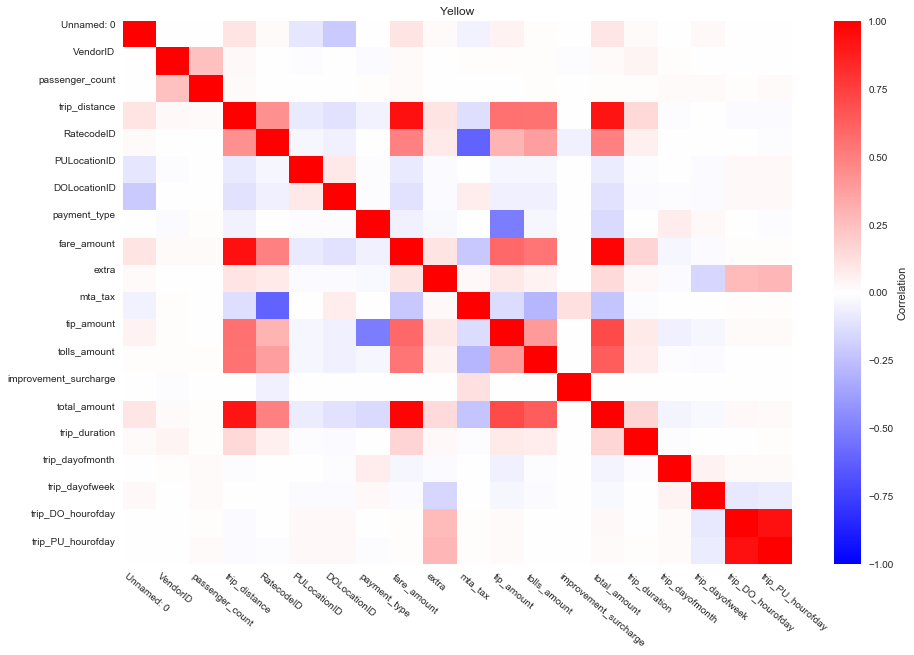

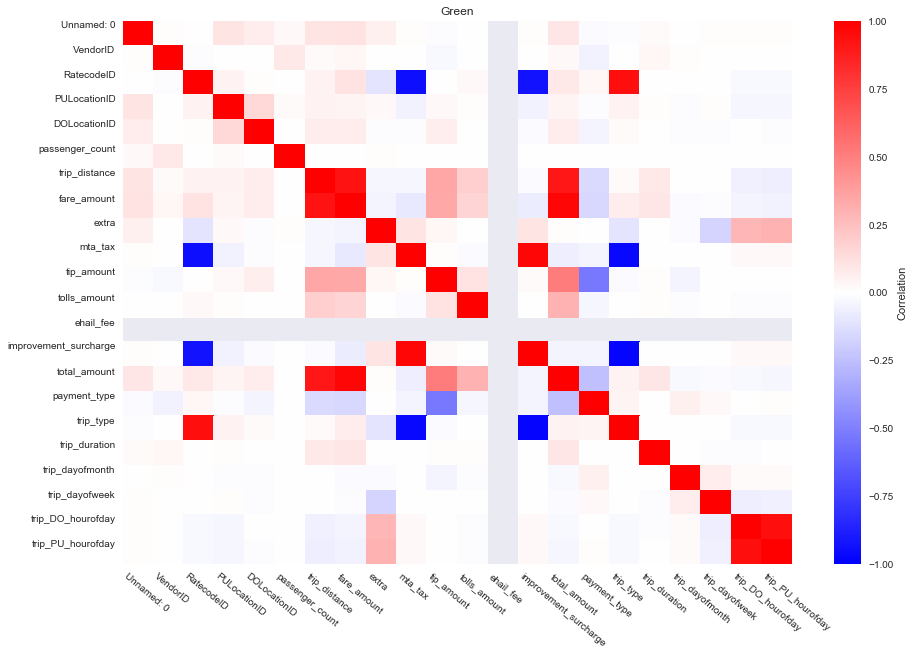

In [5]:
def plot_heat_maps(data, titles):
    for i in range(len(data)):
        fig, ax = plt.subplots()

        corr_mat = data[i].corr()

        #fig.add_subplot(2,1,i+1)
        heatmap = ax.pcolor(corr_mat, cmap='bwr', vmin=-1, vmax=1)
        ax.set_xticks(np.arange(corr_mat.shape[0] +.5));
        ax.set_yticks(np.arange(corr_mat.shape[1] +.5));
        ax.invert_yaxis()

        #labels
        col_lbl = corr_mat.columns
        row_lbl = corr_mat.index
        ax.set_xticklabels(col_lbl, rotation=-40,  ha='left');
        ax.set_yticklabels(row_lbl, va='top');
        ax.set_title(titles[i])

        cbar = plt.colorbar(heatmap)
        cbar.set_label('Correlation')
        
plot_heat_maps([yellow_data, green_data], ['Yellow', "Green"])

We can see that there are no outstanding coorelations that are of interest. As seen before on the older data.

It may be of interest to see where people being picked up in Manhattan are going and what time of the day.

Let us look at the frequencies for each day, hour and day of the week.

## Count Plots

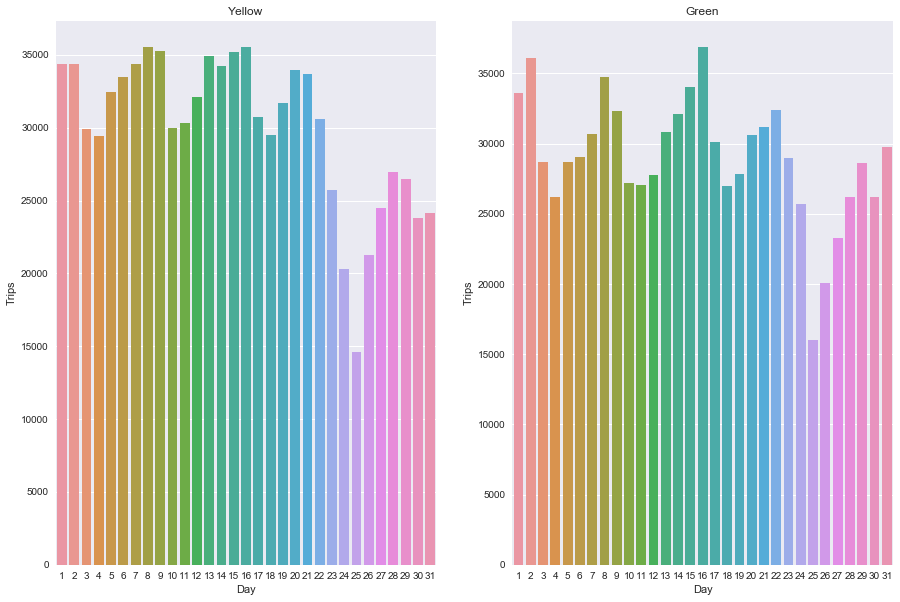

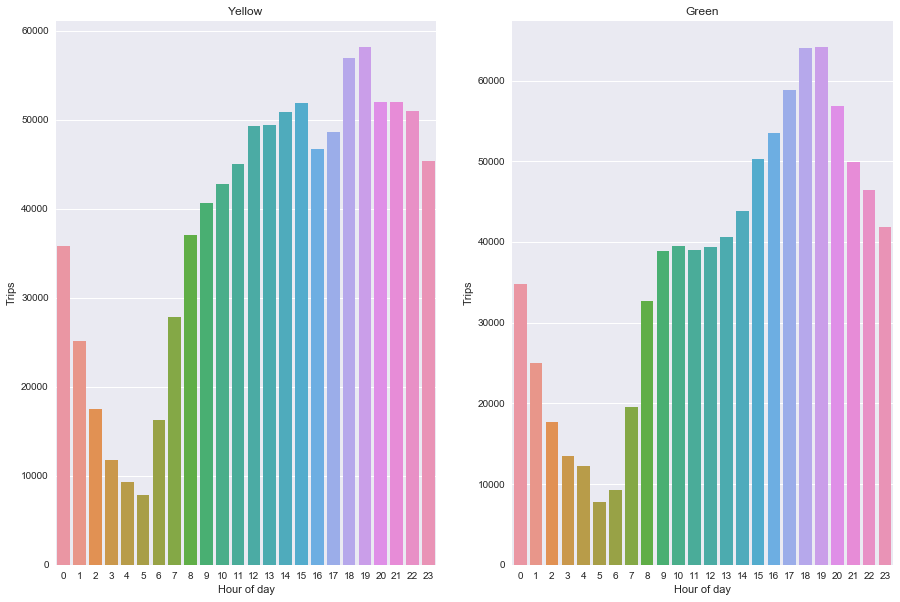

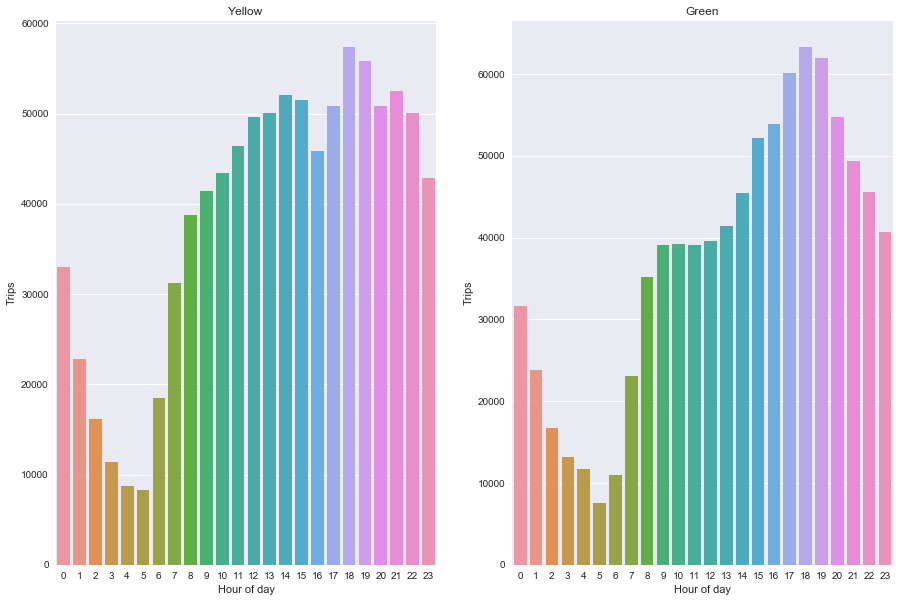

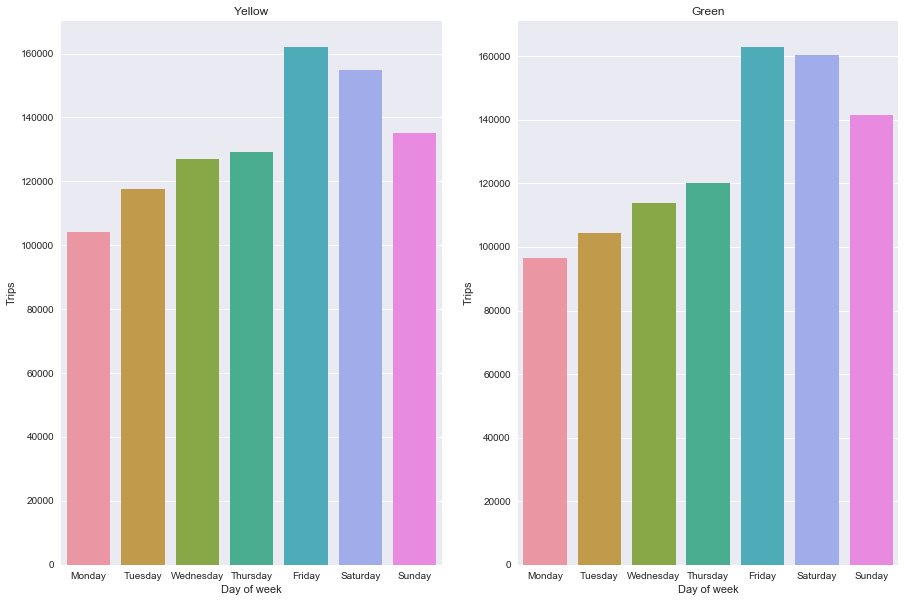

In [6]:
fig = plt.figure()
fig.add_subplot(1,2,1)
sns.countplot(x=yellow_data['trip_dayofmonth'])
fig.add_subplot(1,2,2)
sns.countplot(x=green_data['trip_dayofmonth'])
fig.axes[0].set_title('Yellow')
fig.axes[1].set_title('Green')
for ax in fig.axes:
    ax.set(xlabel="Day", ylabel="Trips")

fig = plt.figure()
fig.add_subplot(1,2,1)
sns.countplot(x=yellow_data['trip_DO_hourofday'])
fig.add_subplot(1,2,2)
sns.countplot(x=green_data['trip_DO_hourofday'])
fig.axes[0].set_title('Yellow')
fig.axes[1].set_title('Green')
for ax in fig.axes:
    ax.set(xlabel='Hour of day',ylabel='Trips')
    
fig = plt.figure()
fig.add_subplot(1,2,1)
sns.countplot(x=yellow_data['trip_PU_hourofday'])
fig.add_subplot(1,2,2)
sns.countplot(x=green_data['trip_PU_hourofday'])
fig.axes[0].set_title('Yellow')
fig.axes[1].set_title('Green')
for ax in fig.axes:
    ax.set(xlabel='Hour of day',ylabel='Trips')

fig = plt.figure()
fig.add_subplot(1,2,1)
sns.countplot(x=yellow_data['trip_dayofweek'])
fig.add_subplot(1,2,2)
sns.countplot(x=green_data['trip_dayofweek'])
fig.axes[0].set_title('Yellow')
fig.axes[1].set_title('Green')
for ax in fig.axes:
    ax.set(xlabel="Day of week", ylabel="Trips")
    ax.set_xticklabels(list(calendar.day_name));

It turns out that in this set of data the most frequent trip days are Friday. And since this is from the month of December we can clearly see the drop in total trips on Christmas day. The demand for taxis during Christmas time is low even on Christmas Eve and the day after. Both yellow and green taxis follow a similar pattern to each other except with more variance in day of the month. This will still work for our purposes. 

## Modeling dropoff location.
Now we will finally look to see if we can predict dropoff locations based on pickup location, day of the week, day of the month (December), hour of the day. We will split the data into training and testing sets and also look at specific starting locations to see what the most common dropoffs are for them since we found earlier that the pickup locations seem to be centralized. I'm assuming that it follows similar behavior to the older data looked at in another notebook.

In [7]:
yellow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929486 entries, 6914626 to 6013468
Data columns (total 27 columns):
Unnamed: 0               929486 non-null int64
VendorID                 929486 non-null int64
tpep_pickup_datetime     929486 non-null datetime64[ns]
tpep_dropoff_datetime    929486 non-null datetime64[ns]
passenger_count          929486 non-null int64
trip_distance            929486 non-null float64
RatecodeID               929486 non-null int64
store_and_fwd_flag       929486 non-null object
PULocationID             929486 non-null int64
DOLocationID             929486 non-null int64
payment_type             929486 non-null int64
fare_amount              929486 non-null float64
extra                    929486 non-null float64
mta_tax                  929486 non-null float64
tip_amount               929486 non-null float64
tolls_amount             929486 non-null float64
improvement_surcharge    929486 non-null float64
total_amount             929486 non-null float64
t

### Spliting the data

In [18]:
y_X = yellow_data.sample(frac=1, random_state=9)[['VendorID', 'passenger_count', 'PULocationID', 'trip_dayofmonth', 'trip_dayofweek','trip_PU_hourofday']]
y_y = yellow_data.sample(frac=1, random_state=9)['DOLocationID']

g_X = green_data[['VendorID', 'passenger_count', 'PULocationID', 'trip_dayofmonth', 'trip_dayofweek','trip_PU_hourofday']]
g_y = green_data['DOLocationID']

In [9]:
y_X.head()

,VendorID,passenger_count,PULocationID,trip_dayofmonth,trip_dayofweek,trip_PU_hourofday
9113954,2,6,161,6,2,10
7021479,1,1,141,26,1,13
3516492,1,1,162,18,0,22
4391214,1,1,142,20,2,14
4214829,2,1,163,7,3,23


In [19]:
g_X.head()

,VendorID,passenger_count,PULocationID,trip_dayofmonth,trip_dayofweek,trip_PU_hourofday
0,1,1,42,1,4,0
1,2,1,42,1,4,5
2,1,2,42,1,4,8
3,2,1,42,1,4,7
4,2,1,42,1,4,10


#### Decision Tree dropoff classification

Yellow:

In [16]:
decisionTree = tree.DecisionTreeClassifier(min_samples_split=345)

y_XTrain, y_XTest, y_yTrain, y_yTest = train_test_split(y_X, y_y, random_state=10, test_size=0.8)
# fit the tree with the traing data
decisionTree = decisionTree.fit(y_XTrain, y_yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(y_XTrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(y_XTest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_yTest, y_pred = y_pred))

print('Confusion Matrix: \n', metrics.confusion_matrix(y_true=y_yTest, y_pred=y_pred))

Accuracy on training data =  0.108506323394
Accuracy on test data =  0.0823761513417
Confusion Matrix: 
 [[ 46   0   1 ...,   0   0   2]
 [  0   0   0 ...,   0   0   1]
 [  0   0  14 ...,   0   4  22]
 ..., 
 [  0   0   1 ...,   0   3  25]
 [  0   0   2 ...,   0  90 392]
 [  0   0   1 ...,   0  98 532]]


Green:

In [47]:
decisionTree = tree.DecisionTreeClassifier(min_samples_split=345)

g_XTrain, g_XTest, g_yTrain, g_yTest = train_test_split(g_X, g_y, random_state=10, test_size=0.8)
# fit the tree with the traing data
decisionTree = decisionTree.fit(g_XTrain, g_yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(g_XTrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = g_yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(g_XTest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = g_yTest, y_pred = y_pred))

print('Confusion Matrix: \n', metrics.confusion_matrix(y_true=g_yTest, y_pred=y_pred))

Accuracy on training data =  0.192922399804
Accuracy on test data =  0.172013103749
Confusion Matrix: 
 [[ 0  0  0 ...,  0  0  1]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  4]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0 12]
 [ 0  0  0 ...,  0  0 63]]


#### K-nearest neighbors dropoff classification

Yellow:

In [46]:
knn_model = KNeighborsClassifier(n_neighbors = 100).fit(y_XTrain, y_yTrain)
ypred = knn_model.predict(y_XTest)

print('Accuracy: ', metrics.accuracy_score(y_true=y_yTest, y_pred= ypred))

print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_yTest, y_pred = ypred))

print('Confusion Matrix: \n', metrics.confusion_matrix(y_true=y_yTest, y_pred=ypred))

Accuracy:  0.0714453817902
Accuracy on test data =  0.0714453817902
Confusion Matrix: 
 [[  1   0   1 ...,   2   0   5]
 [  0   0   0 ...,   0   0   1]
 [  0   0  11 ...,   1   9  36]
 ..., 
 [  1   0   2 ...,   2   5  34]
 [  0   0   3 ...,   0  29 395]
 [  1   0   7 ...,   0  42 502]]


Green:

In [44]:
knn_model = KNeighborsClassifier(n_neighbors = 100).fit(g_XTrain, g_yTrain)
ypred = knn_model.predict(g_XTest)

print('Accuracy: ', metrics.accuracy_score(y_true=g_yTest, y_pred= ypred))

print('Accuracy on test data = ', metrics.accuracy_score(y_true = g_yTest, y_pred = y_pred))

print('Confusion Matrix: \n', metrics.confusion_matrix(y_true=g_yTest, y_pred=ypred))

Accuracy:  0.149863711006
Accuracy on test data =  0.172013103749
Confusion Matrix: 
 [[ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  1]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0 16]
 [ 0  0  0 ...,  0  0 50]]


### Cross-Validation

Now its time for some proper cross validation on both kNN and DT.

Yellow:

C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, whic

Best split:  500.0
Best score:  0.0868501242893


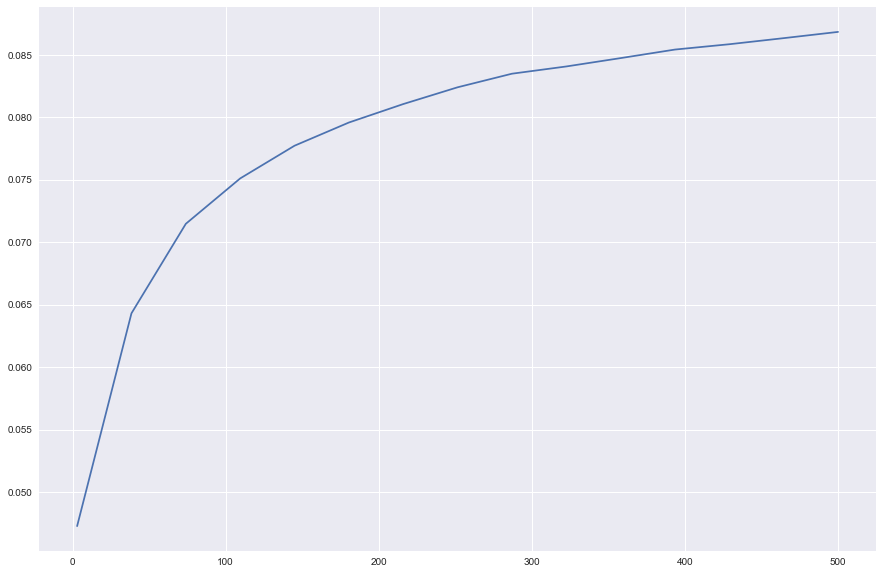

In [34]:
#cross validation

min_split = np.linspace(3, 500, 15)
Accuracies = np.zeros(min_split.shape[0])

for i, split in enumerate(min_split):
    decisionTree = tree.DecisionTreeClassifier(min_samples_split=int(split))
    scores = cross_val_score(decisionTree, y_X, y=y_y)
    Accuracies[int(i)] = scores.mean()

print('Best split: ', min_split[np.argmax(Accuracies)])
print('Best score: ', max(Accuracies))

plt.plot(min_split,Accuracies)
plt.show()

<b>*Interpretation:*</b> The best min sample split tapers off at 500. The increase from 345 to 500 only increased the accuracy by .4%. This accuracy score is not very high at all but picking a dropoff location at random has a .38% chance of getting it correct. So the decision tree is about 21 times better at predicting dropoff location than a naive random approach. 

C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, whic

Best k:  278.222222222
Best Accuracy:  0.0792060891763


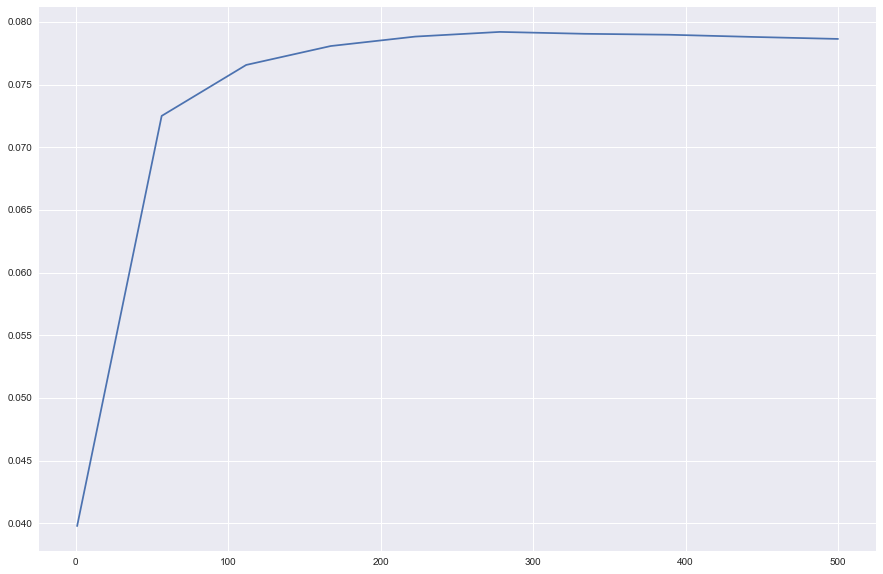

In [38]:
#cross validation
ks = np.linspace(1, 500, 10)
Accuracies = np.zeros(ks.shape[0])

for i, k in enumerate(ks):
    knn_cross = KNeighborsClassifier(n_neighbors=int(k))
    scores = cross_val_score(knn_cross, y_X, y=y_y)
    Accuracies[int(i)] = scores.mean()

print('Best k: ', ks[np.argmax(Accuracies)])
print('Best Accuracy: ', max(Accuracies))

plt.plot(ks,Accuracies)
plt.show()

<b>*Interpretation:*</b> The best k tapers off at 278. This has a similar interpretation to the DT cross-validation.

Green:

C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, whic

Best split:  400.0
Best score:  0.014163558445


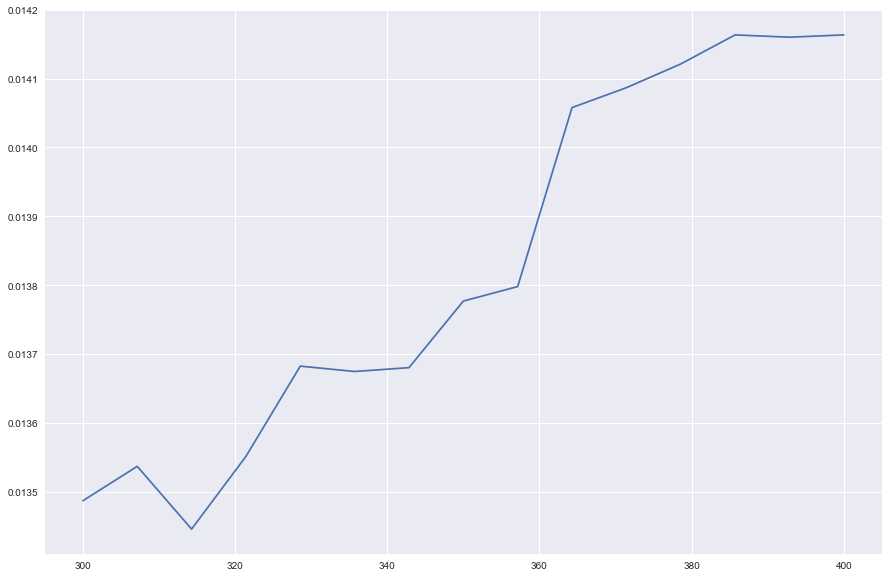

In [43]:
#cross validation

min_split = np.linspace(300, 400, 15)
Accuracies = np.zeros(min_split.shape[0])

for i, split in enumerate(min_split):
    decisionTree = tree.DecisionTreeClassifier(min_samples_split=int(split))
    scores = cross_val_score(decisionTree, g_X, y=g_y)
    Accuracies[int(i)] = scores.mean()

print('Best split: ', min_split[np.argmax(Accuracies)])
print('Best score: ', max(Accuracies))

plt.plot(min_split,Accuracies)
plt.show()

<b>*Interpretation:*</b> The DT for the green resulted in a score of 1.4% this is also not great but still better than a random process.

C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Lukas Gust\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, whic

Best k:  200.0
Best Accuracy:  0.0385780186544


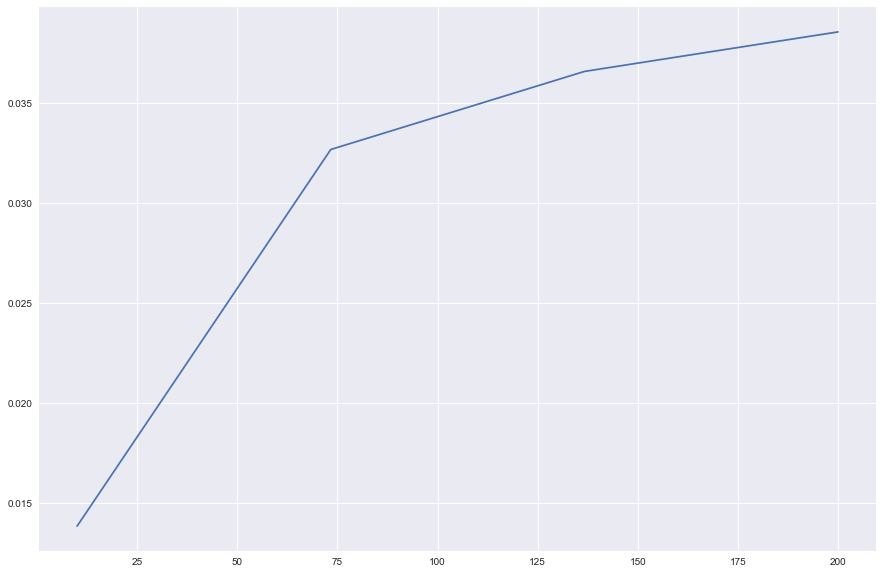

In [42]:
#cross validation
ks = np.linspace(10, 200, 4)
Accuracies = np.zeros(ks.shape[0])

for i, k in enumerate(ks):
    knn_cross = KNeighborsClassifier(n_neighbors=int(k))
    scores = cross_val_score(knn_cross, g_X, y=g_y)
    Accuracies[int(i)] = scores.mean()

print('Best k: ', ks[np.argmax(Accuracies)])
print('Best Accuracy: ', max(Accuracies))

plt.plot(ks,Accuracies)
plt.show()

<b>*Interpretation:*</b> The accuracy tapers off for 200 nearest neighbors. The accuracy is not that great although it is still better than a random process.